In [1]:
from IPython.display import display, HTML
display(HTML ("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input{font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [4]:
import os # 모델 저장할 폴더가 있는 여부와 폴더 생성
import numpy as np
import pandas as pd # get_dummies(원핫인코딩), crosstab
import seaborn as sns # iris 데이터 프레임 가져오기
from sklearn import datasets # iris 데이터(X, y) 가져오기
from sklearn.preprocessing import LabelEncoder # 라벨인코더
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras import metrics # compile
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
import matplotlib.pyplot as plt

- 데이터 셋 생성(seaborn) & 전처리
    X, y(라벨인코딩)분리 -> train과 test셋 분리(8:2)
- 모델 구성(입력4 -> 출력3, layer5: 4-> 64 -> 128-> 50 -> 30 -> 3)
- 모델 학습과정 설정
- 모델 학습(earlystopping, ModelCheckpoint추가)
- 모델 평가(시각화, 현재모델과 저장된 최고의 모델 평가, 교차표==혼동행렬)
- 모델예측/저장

In [7]:
iris = sns.load_dataset('iris')
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [11]:
X_iris = iris.iloc[:, :-1].values # to_numpy와 유사. numpy배열로
y_iris = iris.iloc[:, -1]
X_iris.shape, y_iris.shape

((150, 4), (150,))

In [12]:
# 독립변수 X의 스케일 조정
scaler = StandardScaler()
scaler.fit(X_iris)
scaled_X_iris = scaler.transform(X_iris)
# 다중분류를 위한 타겟변수의 원핫인코딩 -> numpy 배열로 변환
Y_iris = pd.get_dummies(y_iris).to_numpy()

In [13]:
scaled_X_iris.shape, Y_iris.shape

((150, 4), (150, 3))

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X_iris,
                                                   Y_iris,
                                                   #test_size=0.3,
                                                   train_size=0.7,
                                                   stratify=Y_iris, #층화추출
                                                   random_state=12)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((105, 4), (105, 3), (45, 4), (45, 3))

In [15]:
np.c_[pd.Series(Y_iris.argmax(axis=1)).value_counts(normalize=True),
pd.Series(Y_train.argmax(axis=1)).value_counts(normalize=True),
pd.Series(Y_test.argmax(axis=1)).value_counts(normalize=True)]

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [16]:
model = Sequential()
model.add(Input(4))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(50, 'relu'))
model.add(Dense(30, 'relu'))
model.add(Dense(units=3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 50)                6450      
                                                                 
 dense_3 (Dense)             (None, 30)                1530      
                                                                 
 dense_4 (Dense)             (None, 3)                 93        
                                                                 
Total params: 16,713
Trainable params: 16,713
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(loss='categorical_crossentropy', # sparse_categoricla_crossentropy
             optimizer='adam',
             metrics=['accuracy']) # 평가지표

In [25]:
%%time
class CustomHistory(Callback): #on_epoch_end()함수가 epoch수행후 자동 호출
    def __init__(self):
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if (self.epoch%5 == 0) | (self.epoch==1):
            print('{}번째 loss:{:.4f}, acc:{:.4f}, val_loss:{:.4f},val_acc:{:.4f}'\
                 .format(self.epoch,
                        logs.get('loss'),
                        logs.get('accuracy'),
                        logs.get('val_loss'),
                        logs.get('val_accuracy')
                        )
                 )
model_save_folder = './model/'
import os
if not os.path.exists(model_save_folder): # 폴더 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'iris-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'
customHistory = CustomHistory()
checkpoint = ModelCheckpoint(
                    filepath=file,
                    mointor = 'val_accuracy', # 모니터링 지표: loss, val_loss, accuracy
                    save_best_only = True, # 모니터링 지표가 개선된 경우만 저장
                    mode = 'max',
                    verbose=0) # 로그 출력 여부
earlyStopping = EarlyStopping(monitor='val_loss', patience=20)
hist = model.fit(X_train, Y_train, epochs=200, batch_size=200,
                validation_split=0.1, # 학습셋의 20%는 검증셋으로
                verbose = 0, #로그출력 막음(콜백함수에서 출력)
                callbacks = [earlyStopping,
                            customHistory,
                            checkpoint])

1번째 loss:0.0015, acc:1.0000, val_loss:0.0001,val_acc:1.0000
5번째 loss:0.0014, acc:1.0000, val_loss:0.0001,val_acc:1.0000
10번째 loss:0.0013, acc:1.0000, val_loss:0.0001,val_acc:1.0000
15번째 loss:0.0012, acc:1.0000, val_loss:0.0001,val_acc:1.0000
20번째 loss:0.0011, acc:1.0000, val_loss:0.0000,val_acc:1.0000
25번째 loss:0.0010, acc:1.0000, val_loss:0.0000,val_acc:1.0000
30번째 loss:0.0009, acc:1.0000, val_loss:0.0000,val_acc:1.0000
35번째 loss:0.0009, acc:1.0000, val_loss:0.0000,val_acc:1.0000
40번째 loss:0.0008, acc:1.0000, val_loss:0.0000,val_acc:1.0000
45번째 loss:0.0007, acc:1.0000, val_loss:0.0000,val_acc:1.0000
50번째 loss:0.0007, acc:1.0000, val_loss:0.0000,val_acc:1.0000
55번째 loss:0.0007, acc:1.0000, val_loss:0.0000,val_acc:1.0000
60번째 loss:0.0006, acc:1.0000, val_loss:0.0000,val_acc:1.0000
65번째 loss:0.0006, acc:1.0000, val_loss:0.0000,val_acc:1.0000
70번째 loss:0.0006, acc:1.0000, val_loss:0.0000,val_acc:1.0000
75번째 loss:0.0005, acc:1.0000, val_loss:0.0000,val_acc:1.0000
80번째 loss:0.0005, acc:1.00

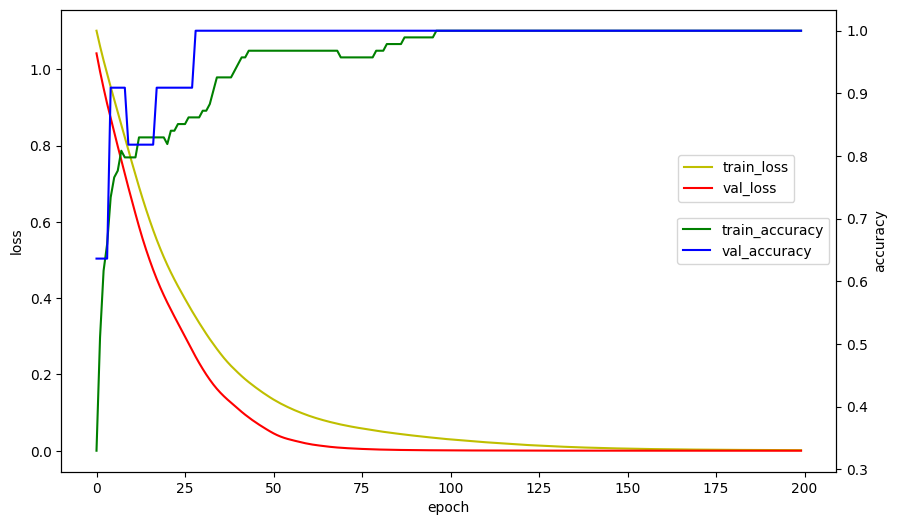

In [23]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [27]:
loss_and_acc = model.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print(f'loss:{loss_and_acc[0]:.4f}, accuracy:{loss_and_acc[1]:.4f}')

loss:0.3710, accuracy:0.9333


In [26]:
model1 = load_model('model/iris-001-loss0.0001-acc1.0000.h5')
loss_and_acc1 = model1.evaluate(X_test, Y_test, verbose=0)
print(f'loss:{loss_and_acc[0]:.4f}, accuracy:{loss_and_acc[1]:.4f}')

loss:0.3076, accuracy:0.9333


In [28]:
model.save('model/iris.h5')

In [29]:
# 교차표 (실제값과 예측값을 1차원 데이터로)
real = Y_test.argmax(axis=1) + 3 # 실제값
# real = np.argmax(Y_test, axis=1)
pred = model.predict(X_test).argmax(axis=1) + 3
#pred = np.argmax(model.predict(X_test), axis=1)

pd.crosstab(real, pred, rownames=['real'], colnames=['predict'])

2/2 [==============================] - 0s 2ms/step


predict,3,4,5
real,,,
3,15,0,0
4,0,14,1
5,0,2,13


In [30]:
X_iris[0]

array([5.1, 3.5, 1.4, 0.2])

In [31]:
input_data = [5.1, 3.5, 1.4, 0.2]
scaled_data = scaler.transform([input_data])
model.predict(scaled_data).argmax(axis=1)+3

1/1 [==============================] - 0s 16ms/step


array([3], dtype=int64)

In [32]:
import os # 모델 저장할 폴더가 있는 여부와 폴더 생성
import numpy as np
import pandas as pd # get_dummies(원핫인코딩), crosstab
import seaborn as sns # iris 데이터 프레임 가져오기
from sklearn import datasets # iris 데이터(X, y) 가져오기
from sklearn.preprocessing import LabelEncoder # 라벨인코더
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras import metrics # compile
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
import matplotlib.pyplot as plt

In [33]:
iris = sns.load_dataset('iris')
iris.loc[::50]

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
50,7.0,3.2,4.7,1.4,versicolor
100,6.3,3.3,6.0,2.5,virginica


In [34]:
# 문자변수 원핫인코딩 방법1
encoder = LabelEncoder()
iris['y'] = encoder.fit_transform(iris['species'])
display(iris.loc[::50])
# utils.to_categorical(iris['species'])[:5]
# to_categorical을 하려면 숫자필드로 라벨인코딩먼저
to_categorical(iris['y'])[::50]

,sepal_length,sepal_width,petal_length,petal_width,species,y
0,5.1,3.5,1.4,0.2,setosa,0
50,7.0,3.2,4.7,1.4,versicolor,1
100,6.3,3.3,6.0,2.5,virginica,2


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [35]:
# 문자변수 원핫인코딩 방법2
pd.get_dummies(iris.species)[::50]

,setosa,versicolor,virginica
0,1,0,0
50,0,1,0
100,0,0,1


In [36]:
# 1. 데이터 생성 및 전처리
iris = sns.load_dataset('iris')
# 독립변수와 종속변수 분리
iris_X = iris.iloc[:, :-1].to_numpy()
iris_y = iris.iloc[:, -1]
iris_Y = pd.get_dummies(iris_y).values
# 훈련셋 : 테스트셋 = 8 : 2
X_train, X_test, Y_train, Y_test = train_test_split(iris_X, iris_Y,
                                                   test_size=0.2,
                                                   stratify=iris_Y, # 층화추출
                                                   random_state=4) 
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((120, 4), (120, 3), (30, 4), (30, 3))

In [37]:
# 층화 추출했는지 확인 
pd.Series(np.argmax(Y_train, axis=1)).value_counts()

0    40
1    40
2    40
dtype: int64

In [38]:
pd.Series(np.argmax(Y_test, axis=1)).value_counts()

1    10
2    10
0    10
dtype: int64

In [39]:
model = Sequential()
model.add(Dense(units=64, input_dim=4, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=30, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                320       
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 50)                6450      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 30)                1530      
                                                                 
 dropout_2 (Dropout)         (None, 30)               

In [40]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [41]:
model_save_folder = './model/'
import os
if not os.path.exists(model_save_folder): # 폴더 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder \
        + 'iris-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'
# 콜백객체
checkpoint = ModelCheckpoint(
                    filepath=file,
                    monitor='val_accuracy', # 모니터링 지표:loss, val_loss, accuracy
                    save_best_only=True,    # 모니터링 지표가 개선된 경우만 저장
                    mode = 'max',
                    verbose=1) # 로그 출력 여부
earlystopping = EarlyStopping(patience=40)# monitor='val_loss' 기본값
hist=model.fit(X_train,Y_train,batch_size=40,
               epochs=200,
               validation_split=0.2,
               callbacks=[checkpoint,earlystopping])

Epoch 1/200
1/3 [=========>....................] - ETA: 0s - loss: 1.1792 - accuracy: 0.3500
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to ./model\iris-001-loss1.0152-acc0.6667.h5
3/3 [==============================] - 1s 78ms/step - loss: 1.1479 - accuracy: 0.3229 - val_loss: 1.0152 - val_accuracy: 0.6667
Epoch 2/200
1/3 [=========>....................] - ETA: 0s - loss: 1.0817 - accuracy: 0.3750
Epoch 2: val_accuracy improved from 0.66667 to 0.87500, saving model to ./model\iris-002-loss0.9368-acc0.8750.h5
3/3 [==============================] - 0s 21ms/step - loss: 1.0633 - accuracy: 0.4062 - val_loss: 0.9368 - val_accuracy: 0.8750
Epoch 3/200
1/3 [=========>....................] - ETA: 0s - loss: 1.0403 - accuracy: 0.4250
Epoch 3: val_accuracy did not improve from 0.87500
3/3 [==============================] - 0s 15ms/step - loss: 1.0164 - accuracy: 0.4688 - val_loss: 0.8440 - val_accuracy: 0.8750
Epoch 4/200
1/3 [=========>....................] - ETA: 0s - lo

1/3 [=========>....................] - ETA: 0s - loss: 0.2182 - accuracy: 0.8750
Epoch 30: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 13ms/step - loss: 0.2331 - accuracy: 0.8958 - val_loss: 0.0905 - val_accuracy: 1.0000
Epoch 31/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2216 - accuracy: 0.9250
Epoch 31: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 12ms/step - loss: 0.2447 - accuracy: 0.9271 - val_loss: 0.0726 - val_accuracy: 1.0000
Epoch 32/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2081 - accuracy: 0.9500
Epoch 32: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 14ms/step - loss: 0.2377 - accuracy: 0.9375 - val_loss: 0.0795 - val_accuracy: 1.0000
Epoch 33/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1850 - accuracy: 0.9750
Epoch 33: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 13m

Epoch 60/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1098 - accuracy: 0.9500
Epoch 60: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 14ms/step - loss: 0.1413 - accuracy: 0.9375 - val_loss: 0.0721 - val_accuracy: 0.9583
Epoch 61/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2280 - accuracy: 0.8750
Epoch 61: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 13ms/step - loss: 0.1645 - accuracy: 0.9271 - val_loss: 0.0376 - val_accuracy: 1.0000
Epoch 62/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1341 - accuracy: 0.9500
Epoch 62: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 13ms/step - loss: 0.1353 - accuracy: 0.9375 - val_loss: 0.0196 - val_accuracy: 1.0000
Epoch 63/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1576 - accuracy: 0.9250
Epoch 63: val_accuracy did not improve from 1.00000
3/3 [===========================

Epoch 90/200
1/3 [=========>....................] - ETA: 0s - loss: 0.2111 - accuracy: 0.9250
Epoch 90: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 13ms/step - loss: 0.1166 - accuracy: 0.9583 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 91/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0461 - accuracy: 1.0000
Epoch 91: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 12ms/step - loss: 0.1008 - accuracy: 0.9688 - val_loss: 0.0178 - val_accuracy: 1.0000
Epoch 92/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1203 - accuracy: 0.9250
Epoch 92: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 13ms/step - loss: 0.1249 - accuracy: 0.9479 - val_loss: 0.0357 - val_accuracy: 1.0000
Epoch 93/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0463 - accuracy: 1.0000
Epoch 93: val_accuracy did not improve from 1.00000
3/3 [===========================

Epoch 120/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0355 - accuracy: 1.0000
Epoch 120: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 13ms/step - loss: 0.0940 - accuracy: 0.9583 - val_loss: 0.0334 - val_accuracy: 1.0000
Epoch 121/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0713 - accuracy: 1.0000
Epoch 121: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 13ms/step - loss: 0.0947 - accuracy: 0.9896 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 122/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0656 - accuracy: 0.9500
Epoch 122: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 13ms/step - loss: 0.1230 - accuracy: 0.9583 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 123/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1635 - accuracy: 0.9750
Epoch 123: val_accuracy did not improve from 1.00000
3/3 [===================

Epoch 150/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0227 - accuracy: 1.0000
Epoch 150: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 13ms/step - loss: 0.0688 - accuracy: 0.9896 - val_loss: 0.0187 - val_accuracy: 1.0000
Epoch 151/200
1/3 [=========>....................] - ETA: 0s - loss: 0.1171 - accuracy: 0.9750
Epoch 151: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 13ms/step - loss: 0.0682 - accuracy: 0.9792 - val_loss: 0.0292 - val_accuracy: 1.0000
Epoch 152/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0171 - accuracy: 1.0000
Epoch 152: val_accuracy did not improve from 1.00000
3/3 [==============================] - 0s 13ms/step - loss: 0.0908 - accuracy: 0.9688 - val_loss: 0.0133 - val_accuracy: 1.0000
Epoch 153/200
1/3 [=========>....................] - ETA: 0s - loss: 0.0270 - accuracy: 1.0000
Epoch 153: val_accuracy did not improve from 1.00000
3/3 [===================

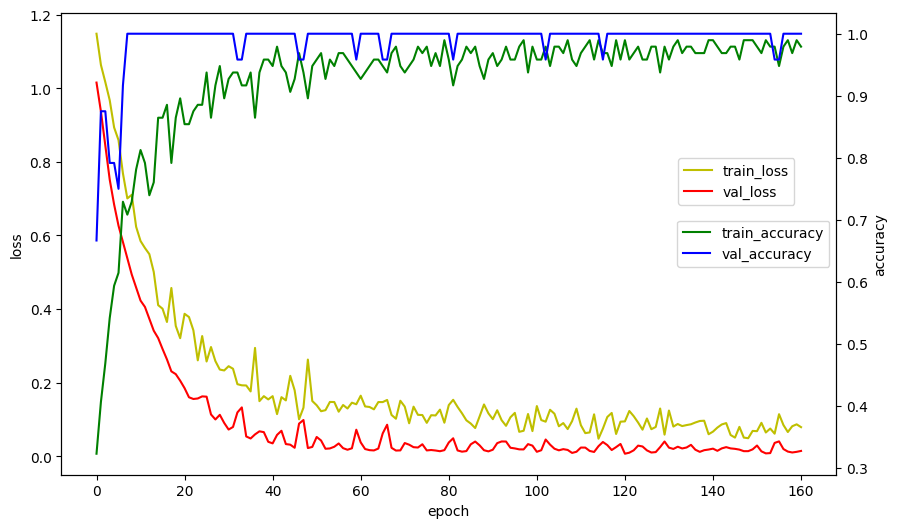

In [42]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [45]:
# 모델 평가
loss_and_acc =model.evaluate(X_test, Y_test, verbose=0)
print(f'loss:{loss_and_acc[0]:.4f}, accuracy:{loss_and_acc[1]:.4f}')

loss:0.1169, accuracy:0.9333


In [46]:
model1 = load_model('model/iris-008-loss0.5377-acc1.0000.h5')
loss_and_acc1 = model1.evaluate(X_test, Y_test, verbose=0)
print(f'loss:{loss_and_acc[0]:.4f}, accuracy:{loss_and_acc[1]:.4f}')

loss:0.1169, accuracy:0.9333


In [48]:
model2 = load_model('model/iris-001-loss0.0001-acc1.0000.h5')
loss_and_acc2 =model2.evaluate(X_test, Y_test, verbose=0)
print(f'loss:{loss_and_acc2[0]:.4f}, accuracy:{loss_and_acc2[1]:.4f}')

loss:26.7300, accuracy:0.3333


In [49]:
# 교차표 (실제값과 예측값을 1차원 데이터로)
real = Y_test.argmax(axis=1) + 3 # 실제값
# real = np.argmax(Y_test, axis=1)
pred = model.predict(X_test).argmax(axis=1) + 3
#pred = np.argmax(model.predict(X_test), axis=1)

pd.crosstab(real, pred, rownames=['real'], colnames=['predict'])

1/1 [==============================] - 0s 52ms/step


predict,3,4,5
real,,,
3,10,0,0
4,0,8,2
5,0,0,10


In [51]:
X_iris[0]

array([5.1, 3.5, 1.4, 0.2])

In [52]:
input_data = [5.1, 3.5, 1.4, 0.2]
scaled_data = scaler.transform([input_data])
model.predict(scaled_data).argmax(axis=1)+3

1/1 [==============================] - 0s 16ms/step


array([3], dtype=int64)